# Try transfer learning using WGAN critic/discriminator
# V3

adapt from here https://github.com/ck44liu/gans-on-image-classification/blob/main/report%20gan%20assignment.pdf

if this doesn't work then try this next, https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/

https://www.mdpi.com/2227-7390/10/9/1541


In [7]:
from tensorflow.keras.models import load_model
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv3D, Conv3DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, multiply, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
import numpy as np
import glob
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from sklearn.model_selection import train_test_split
import random

In [8]:
critic = load_model('wgan_critic_model_v3.h5')

freeze the original layers of the model to retain the learned features before adding classification layers

In [9]:
critic.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 84, 84, 72, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 42, 42, 36, 64)    1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 42, 42, 36, 64)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 18, 128)   221312    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 21, 21, 18, 128)   0         
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                                                                 
 dense_1 (Dense)             (None, 128)               1300

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

new_model = Sequential()
for i in range(len(critic.layers)-1):  # Excluding the last layer
    layer = critic.layers[i]
    layer.trainable = False  # Freeze the layer
    new_model.add(layer)

# Adding additional layers
new_model.add(BatchNormalization())
new_model.add(Dense(128, activation='relu', name = 'dense_9'))
new_model.add(Dropout(0.3))
new_model.add(Dense(64, activation='relu', name = 'dense_5'))
new_model.add(Dropout(0.3))
new_model.add(Dense(1, activation='sigmoid', name = 'dense_6'))  # Sigmoid for binary classification




In [47]:
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 42, 42, 36, 64)    1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 42, 42, 36, 64)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 18, 128)   221312    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 21, 21, 18, 128)   0         
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                                                                 
 dense_1 (Dense)             (None, 128)               130056320 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128)             

# Since we have only one dataset, split it into training and evaluation parts. 

## for classification training, use 50 control and 50 schizphrenia

In [12]:
# Specify the directory and file pattern
directory_path = '../4D'
file_pattern = 'A*_????_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz'

# Construct the full path pattern
path_pattern = f'{directory_path}/{file_pattern}'

# Use glob to find all matching files
matching_files = glob.glob(path_pattern)

# Define the list of schizophrenia IDs

'''
schizophrenia_ids = [
    'A00009280', 'A00028806', 'A00023132', 'A00014804', 'A00016859', 'A00021598', 'A00001181', 'A00023158',] '''

full_schizophrenia_ids = [
    'A00009280', 'A00028806', 'A00023132', 'A00014804', 'A00016859', 'A00021598', 'A00001181', 'A00023158',
    'A00024568', 'A00028405', 'A00001251', 'A00000456', 'A00015648', 'A00002405', 'A00027391', 'A00016720',
    'A00018434', 'A00016197', 'A00027119', 'A00006754', 'A00009656', 'A00038441', 'A00012767', 'A00034273',
    'A00028404', 'A00035485', 'A00024684', 'A00018979', 'A00027537', 'A00004507', 'A00001452', 'A00023246',
    'A00027410', 'A00014719', 'A00024510', 'A00000368', 'A00019293', 'A00014830', 'A00015201', 'A00018403',
    'A00037854', 'A00024198', 'A00001243', 'A00014590', 'A00002337', 'A00024953', 'A00037224', 'A00027616',
    'A00001856', 'A00037619', 'A00024228', 'A00038624', 'A00037034', 'A00037649', 'A00022500', 'A00013216',
    'A00020787', 'A00028410', 'A00002480', 'A00028303', 'A00020602', 'A00024959', 'A00018598', 'A00014636',
    'A00019349', 'A00017147', 'A00023590', 'A00023750', 'A00031597', 'A00015518', 'A00018317', 'A00016723',
    'A00021591', 'A00023243', 'A00017943', 'A00023366', 'A00014607', 'A00020414', 'A00035003', 'A00028805',
    'A00029486', 'A00000541', 'A00028408', 'A00000909', 'A00031186', 'A00000838' ]

schizophrenia_ids = random.sample(full_schizophrenia_ids, 50)
# Define the list of IDs of individuals with non-schizophrenia - control only

'''control_ids = [
    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810', 'A00002198', 'A00020895', 'A00004667'] '''

full_control_ids = [
    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810', 'A00002198', 'A00020895', 'A00004667',
    'A00015826', 'A00023120', 'A00022837', 'A00010684', 'A00009946', 'A00037318', 'A00033214', 'A00022490',
    'A00023848', 'A00029452', 'A00037564', 'A00036555', 'A00023095', 'A00022729', 'A00024955', 'A00024160',
    'A00011725', 'A00027487', 'A00024446', 'A00014898', 'A00015759', 'A00028409', 'A00017294', 'A00014522',
    'A00012995', 'A00031764', 'A00025969', 'A00033147', 'A00018553', 'A00023143', 'A00036916', 'A00028052',
    'A00023337', 'A00023730', 'A00020805', 'A00020984', 'A00000300', 'A00010150', 'A00024932', 'A00035537',
    'A00022509', 'A00028406', 'A00004087', 'A00035751', 'A00023800', 'A00027787', 'A00022687', 'A00023866',
    'A00021085', 'A00022619', 'A00036897', 'A00019888', 'A00021058', 'A00022835', 'A00037495', 'A00026945',
    'A00018716', 'A00026907', 'A00023330', 'A00016199', 'A00037238', 'A00023131', 'A00014120', 'A00021072',
    'A00037665', 'A00022400', 'A00003150', 'A00024372', 'A00021081', 'A00022592', 'A00022653', 'A00013816',
    'A00014839', 'A00031478', 'A00014225', 'A00013363', 'A00037007', 'A00020968', 'A00024301', 'A00024820',
    'A00035469', 'A00029226', 'A00022915', 'A00022773', 'A00024663', 'A00036844', 'A00009207', 'A00024535',
    'A00022727', 'A00011265', 'A00024546'
]

control_ids = random.sample(full_control_ids, 50)

# Initialize lists to store the processed image data, corresponding labels, and filenames
image_data = []
labels = []  # 1 for schizophrenia, 0 for non-schizophrenia
schizophrenia_files = []
non_schizophrenia_files = []

# Lists for files with insufficient time dimensions
insufficient_time_files = []
insufficient_time_ids = []

# Counters for each category
schizophrenia_count = 0
non_schizophrenia_count = 0
processed_files_count = 0

# Loop through the matching files
for file_path in matching_files:
    # Extract the filename
    filename = os.path.basename(file_path)
    
    # Extract the ID from the filename
    file_id = filename.split('_')[0]
    
    # Load the file
    t1_img = nib.load(file_path)
    t1_data = t1_img.get_fdata()

    # Check if the time dimension is at least 90
    if t1_data.shape[3] < 90:
        insufficient_time_files.append(filename)
        insufficient_time_ids.append(file_id)
        continue  # Skip this file

    # Determine the label based on the ID and increment counters
    if file_id in schizophrenia_ids:
        label = 1  # Schizophrenia
        schizophrenia_count += 1
        schizophrenia_files.append(filename)
    elif file_id in control_ids:
        label = 0  # Non-Schizophrenia
        non_schizophrenia_count += 1
        non_schizophrenia_files.append(filename)
    else:
        continue  # Skip files with IDs not in the provided lists
    
    # Collapse one of the axes by summing
    t1_data_collapsed = np.sum(t1_data, axis=1)
    
    # Append the collapsed image data and label to the respective lists
    image_data.append(t1_data_collapsed)
    labels.append(label)

    # Increment the counter
    processed_files_count += 1

# Print the total number of files processed for each category and their filenames
print(f"Total number of files successfully processed: {processed_files_count}")
print(f"Total number of schizophrenia files: {schizophrenia_count}")
print("Schizophrenia files:", schizophrenia_files)
print(f"Total number of non-schizophrenia files: {non_schizophrenia_count}")
print("Non-Schizophrenia files:", non_schizophrenia_files)

# Print files with insufficient time dimension
print(f"Total number of files with insufficient time dimension: {len(insufficient_time_files)}")
print("Files with insufficient time dimension:", insufficient_time_files)
print("IDs of files with insufficient time dimension:", insufficient_time_ids)

Total number of files successfully processed: 74
Total number of schizophrenia files: 34
Schizophrenia files: ['A00000456_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00000838_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00001251_0015_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00006754_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00012767_0015_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00013216_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00014607_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00014804_0014_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00014830_0010_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00015648_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00016197_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00016720_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00016723_0014_func_FL_F

In [13]:
print(len(image_data))
print(len(labels))

74
74


In [14]:
def resize_image(image, new_shape):
    factors = (
        new_shape[0] / image.shape[0],
        new_shape[1] / image.shape[1],
        new_shape[2] / image.shape[2]
    )
    # Reshape and add a channel dimension
    resized_image = scipy.ndimage.zoom(image, factors, order=1)  # order=1 is bilinear interpolation
    return np.expand_dims(resized_image, axis=-1)  # Add channel dimension

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# Determine the maximum z-dimension size
max_z_size = max(img.shape[2] for img in image_data)
image_data_normalized = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 2 - 1 for img in image_data]

# Pad each image to have a consistent z-dimension size
padded_data = [np.pad(img, ((0, 0), (0, 0), (0, max_z_size - img.shape[2])), mode='constant') for img in image_data_normalized]

# Resize each image in the padded data array
resized_images = [resize_image(img, (84, 84, 72)) for img in padded_data]

# Convert the resized data to a numpy array
resized_images_array = np.array(resized_images)

# Define batch size
batch_size = 10

# labels array corresponding to the images
labels_array = np.array(labels)

# Split the data into training and evaluation sets (80% train, 20% eval)
#X_train, X_eval, y_train, y_eval = train_test_split(resized_images_array, labels_array, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets with labels
##train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
#eval_dataset = tf.data.Dataset.from_tensor_slices((X_eval, y_eval)).batch(batch_size)



In [16]:
#tf.keras.backend.clear_session()

# try cross validation

assess how the results of transferred model generalize to an independent dataset. It provides a better estimate of the model's performance on unseen data compared to a single train-test split.

Cross-validation maximizes the use of data by using each data point for both training and validation at different iterations, useful because of our limited number of images

Reducing Bias: It minimizes the bias that can occur due to the particular way of splitting the dataset. By rotating the validation set across different parts of the data, we get a more comprehensive view of the model's performance.

fine-tune hyperparameters. By evaluating different hyperparameters across various folds, we can identify the settings that work best across multiple subsets of your data.

Try stratified k-fold cross-validation. So each fold is a good representative of the whole by having approximately the same percentage of samples of each target class as the complete set.

In [48]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import tensorflow as tf

# Convert the data and labels to numpy arrays
X = np.array(resized_images_array)
y = np.array(labels_array)

# Define the number of splits
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store metrics
fold_no = 1
avg_accuracy = 0
avg_val_accuracy = 0

for train, test in kfold.split(X, y):
    # Create TensorFlow datasets for this fold's train and test data
    train_dataset = tf.data.Dataset.from_tensor_slices((X[train], y[train])).batch(batch_size)
    eval_dataset = tf.data.Dataset.from_tensor_slices((X[test], y[test])).batch(batch_size)

    # Compile the model (if using a new instance of the model for each fold)
    new_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Fit the model
    print(f'Training for fold {fold_no} ...')
    history = new_model.fit(
        train_dataset,
        epochs=14,
        validation_data=eval_dataset
    )

    # Calculating average metrics
    avg_accuracy += history.history['accuracy'][-1]
    avg_val_accuracy += history.history['val_accuracy'][-1]

    fold_no += 1

# Average metrics across folds
avg_accuracy /= n_splits
avg_val_accuracy /= n_splits

print(f'Average Training Accuracy: {avg_accuracy}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')


Training for fold 1 ...
Epoch 1/14
6/6 [==============================] - 1s 62ms/step - loss: 0.7490 - accuracy: 0.4576 - val_loss: 1.5077 - val_accuracy: 0.4000
Epoch 2/14
6/6 [==============================] - 0s 42ms/step - loss: 0.6036 - accuracy: 0.6949 - val_loss: 2.3045 - val_accuracy: 0.4000
Epoch 3/14
6/6 [==============================] - 0s 42ms/step - loss: 0.4789 - accuracy: 0.8136 - val_loss: 2.8552 - val_accuracy: 0.4000
Epoch 4/14
6/6 [==============================] - 0s 42ms/step - loss: 0.3428 - accuracy: 0.8983 - val_loss: 3.5231 - val_accuracy: 0.4667
Epoch 5/14
6/6 [==============================] - 0s 42ms/step - loss: 0.3318 - accuracy: 0.8475 - val_loss: 4.2660 - val_accuracy: 0.5333
Epoch 6/14
6/6 [==============================] - 0s 42ms/step - loss: 0.3429 - accuracy: 0.8814 - val_loss: 4.9803 - val_accuracy: 0.6000
Epoch 7/14
6/6 [==============================] - 0s 42ms/step - loss: 0.1834 - accuracy: 0.9492 - val_loss: 5.6514 - val_accuracy: 0.6667
Epo

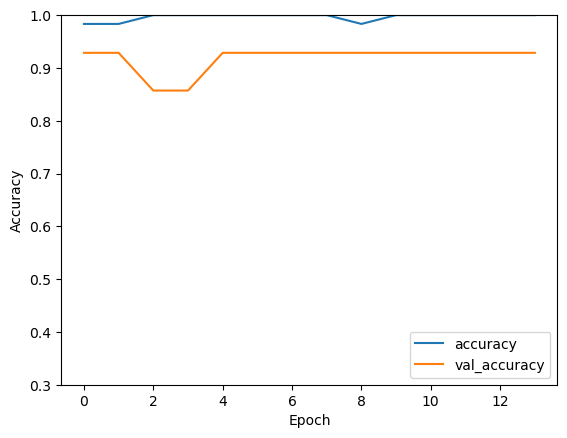

In [49]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

In [22]:
# Make test dataset

# Select 5 control and 5 schizophrenia IDs for the test set

# Randomly select x schizophrenic and y control IDs
schizophrenia_test_ids = random.sample(schizophrenia_ids, 9)
control_test_ids = random.sample(control_ids, 9)

# Now proceed with loading and preprocessing the images for these IDs
test_image_data = []
test_labels = []
# Load and preprocess the images
test_image_data = []
test_labels = []

# Combine all test IDs
test_ids = control_test_ids + schizophrenia_test_ids

# Loop through the matching files and filter based on test IDs
for file_path in matching_files:
    filename = os.path.basename(file_path)
    file_id = filename.split('_')[0]

    # Process only if the ID is in the test set
    if file_id in test_ids:
        t1_img = nib.load(file_path)
        t1_data = t1_img.get_fdata()

        # Ensure sufficient time dimension
        if t1_data.shape[3] < 90:
            continue

        # Collapse one of the axes by summing
        t1_data_collapsed = np.sum(t1_data, axis=1)

        # Resize, normalize, and add dimension as done in the training data preparation
        processed_image = resize_image(t1_data_collapsed, (84, 84, 72))
        processed_image_normalized = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image)) * 2 - 1
        processed_image_final = np.expand_dims(processed_image_normalized, axis=-1)

        test_image_data.append(processed_image_final)
        label = 1 if file_id in schizophrenia_test_ids else 0
        test_labels.append(label)

# Convert to numpy arrays
test_images_array = np.array(test_image_data)
test_labels_array = np.array(test_labels)


test_dataset = tf.data.Dataset.from_tensor_slices((test_images_array, test_labels_array)).batch(batch_size)

# one shot test

In [50]:
# Initialize metrics and lists to store results
test_loss = 0
test_accuracy = 0
num_batches = 0
actual_labels = []
predicted_labels_list = []

# Manually iterate over the test dataset
for images, labels in test_dataset:
    # Make predictions
    predictions = new_model.predict(images)

    # Calculate loss for the batch
    loss = tf.keras.losses.binary_crossentropy(labels, predictions)
    test_loss += tf.reduce_mean(loss).numpy()

    # Process predictions
    predicted_labels_batch = tf.cast(tf.round(predictions), dtype=tf.int32)
    predicted_labels_list.extend(predicted_labels_batch.numpy().flatten())
    actual_labels.extend(labels.numpy().flatten())

    # Calculate accuracy for the batch
    accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predicted_labels_batch), dtype=tf.float32))
    test_accuracy += accuracy.numpy()

    num_batches += 1

# Calculate average loss and accuracy
test_loss /= num_batches
test_accuracy /= num_batches

# Print test results
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
print("Actual labels vs. Predicted labels:")
for i in range(len(actual_labels)):
    print(f"Image {i+1}: Actual: {actual_labels[i]}, Predicted: {predicted_labels_list[i]}")


1/1 [==============================] - 0s 95ms/step
Test Loss: 3.2332890033721924, Test Accuracy: 0.5555555820465088
Actual labels vs. Predicted labels:
Image 1: Actual: 1, Predicted: 0
Image 2: Actual: 0, Predicted: 0
Image 3: Actual: 0, Predicted: 0
Image 4: Actual: 0, Predicted: 0
Image 5: Actual: 1, Predicted: 0
Image 6: Actual: 0, Predicted: 0
Image 7: Actual: 0, Predicted: 0
Image 8: Actual: 1, Predicted: 0
Image 9: Actual: 1, Predicted: 0


In [51]:
# Number of iterations to average results
num_iterations = 10

# Initialize variables to store aggregated results
aggregate_test_loss = 0
aggregate_test_accuracy = 0

# Repeat the testing process for the specified number of iterations
for iteration in range(num_iterations):
    print(f"Testing Iteration: {iteration + 1}")

    # Randomly select x schizophrenic and y control IDs
    schizophrenia_test_ids = random.sample(schizophrenia_ids, 9)
    control_test_ids = random.sample(control_ids, 9)

    # Now proceed with loading and preprocessing the images for these IDs
    test_image_data = []
    test_labels = []
    # Load and preprocess the images
    test_image_data = []
    test_labels = []

    # Combine all test IDs
    test_ids = control_test_ids + schizophrenia_test_ids

    # Loop through the matching files and filter based on test IDs
    for file_path in matching_files:
        filename = os.path.basename(file_path)
        file_id = filename.split('_')[0]

        # Process only if the ID is in the test set
        if file_id in test_ids:
            t1_img = nib.load(file_path)
            t1_data = t1_img.get_fdata()

            # Ensure sufficient time dimension
            if t1_data.shape[3] < 90:
                continue

            # Collapse one of the axes by summing
            t1_data_collapsed = np.sum(t1_data, axis=1)

            # Resize, normalize, and add dimension as done in the training data preparation
            processed_image = resize_image(t1_data_collapsed, (84, 84, 72))
            processed_image_normalized = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image)) * 2 - 1
            processed_image_final = np.expand_dims(processed_image_normalized, axis=-1)

            test_image_data.append(processed_image_final)
            label = 1 if file_id in schizophrenia_test_ids else 0
            test_labels.append(label)

    # Convert to numpy arrays
    test_images_array = np.array(test_image_data)
    test_labels_array = np.array(test_labels)


    test_dataset = tf.data.Dataset.from_tensor_slices((test_images_array, test_labels_array)).batch(batch_size)
    # Initialize metrics for this iteration
    test_loss = 0
    test_accuracy = 0
    num_batches = 0

    # Manually iterate over the test dataset
    for images, labels in test_dataset:
        # Make predictions
        predictions = new_model.predict(images)

        # Calculate loss for the batch
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        test_loss += tf.reduce_mean(loss).numpy()

        # Calculate accuracy for the batch
        predicted_labels_batch = tf.cast(tf.round(predictions), dtype=tf.int32)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predicted_labels_batch), dtype=tf.float32))
        test_accuracy += accuracy.numpy()

        num_batches += 1

        # Calculate average loss and accuracy for this iteration
        test_loss /= num_batches
        test_accuracy /= num_batches

    # Add to aggregate results
    aggregate_test_loss += test_loss
    aggregate_test_accuracy += test_accuracy

    # Print results for this iteration
    print(f"Iteration {iteration + 1} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate and print the average loss and accuracy over all iterations
average_test_loss = aggregate_test_loss / num_iterations
average_test_accuracy = aggregate_test_accuracy / num_iterations
print(f"\nAverage Test Loss over {num_iterations} iterations: {average_test_loss}")
print(f"Average Test Accuracy over {num_iterations} iterations: {average_test_accuracy}")


Testing Iteration: 1
1/1 [==============================] - 0s 19ms/step
Iteration 1 - Test Loss: 1.0950502334162593, Test Accuracy: 0.7899999916553497
Testing Iteration: 2
1/1 [==============================] - 0s 17ms/step
Iteration 2 - Test Loss: 2.555393874645233, Test Accuracy: 0.5999999940395355
Testing Iteration: 3
1/1 [==============================] - 0s 28ms/step
Iteration 3 - Test Loss: 2.564350813627243, Test Accuracy: 0.5949999988079071
Testing Iteration: 4
1/1 [==============================] - 0s 19ms/step
Iteration 4 - Test Loss: 2.7843761444091797, Test Accuracy: 0.5
Testing Iteration: 5
1/1 [==============================] - 0s 24ms/step
Iteration 5 - Test Loss: 2.7373902797698975, Test Accuracy: 0.550000011920929
Testing Iteration: 6
1/1 [==============================] - 0s 20ms/step
Iteration 6 - Test Loss: 2.9793405532836914, Test Accuracy: 0.550000011920929
Testing Iteration: 7
1/1 [==============================] - 0s 18ms/step
Iteration 7 - Test Loss: 2.3259204

WHY IS IT KEEP FLUCTUATING?!